In [170]:
import re
import time
import pandas as pd
import numpy as np
from collections import defaultdict
import matplotlib
import matplotlib.pyplot as plt
import pickle as pickle

# for plotting
%matplotlib inline
import cufflinks as cf
from plotly.offline import download_plotlyjs,init_notebook_mode,plot,iplot
init_notebook_mode(connected=True)
cf.go_offline()

pd.options.display.max_rows=80
pd.options.display.max_colwidth=80
train_file = '../../Fake_TV_Transcript_Generator/ST_TNG/scraped_lines.pkl'

In [212]:
df = pd.read_pickle(train_file)
df.head()

Character  \
0      WORF   
1     RIKER   
2      WORF   
3     RIKER   
4      WORF   

                                                                              Line  \
0  Personal log, stardate 47391.2. I am returning from the Bat'leth competition...   
1  It looks like we're going to have to head into to the Argus Array. This is t...   
2                                                                   Hmm? Yes, sir.   
3               You seem awfully tense for a man who just came back from vacation.   
4                                                            Today is my birthday.   

     Episode  
0  Parallels  
1  Parallels  
2  Parallels  
3  Parallels  
4  Parallels

In [213]:
with open('sent_analysis.txt','r') as infile:
    lines = infile.readlines()
for i in range(len(lines)):
    line = lines[i]
    line = line.replace('\"','').replace('\n', '')
    line = line.split(',')
    line_lst = [0,0]
    line_lst[0] = line.pop(0)
    line_lst[1] = ",".join(line)
    lines[i] = line_lst
lines = pd.DataFrame(lines, columns=['Sentiment', 'Line'])        
lines.head()

Sentiment  \
0         2   
1         2   
2         0   
3         2   
4         2   

                                                                              Line  
0                                                Someone sure stripped this place.  
1                                                              The reactor's gone.  
2  No wonder they didn't answer our hail for two days. Nothing here to answer w...  
3                      Commander, I am detecting life signs from behind that door.  
4                                                                            Worf!

In [215]:
lines['Episode'] = ''
lines['Character'] = ''

for idx, row in lines.iterrows():
    l = row.Line
    try:
        episode = df[df.Line == l]['Episode'].item()
        char = df[df.Line == l]['Character'].item()
    except ValueError:
        episode = ''
        char = ''
    lines.at[idx,'Episode'] = episode
    lines.at[idx,'Character'] = char
lines.head()    

Sentiment  \
0         2   
1         2   
2         0   
3         2   
4         2   

                                                                              Line  \
0                                                Someone sure stripped this place.   
1                                                              The reactor's gone.   
2  No wonder they didn't answer our hail for two days. Nothing here to answer w...   
3                      Commander, I am detecting life signs from behind that door.   
4                                                                            Worf!   

                Episode Character  
0  The Vengeance Factor     RIKER  
1  The Vengeance Factor      WORF  
2  The Vengeance Factor     RIKER  
3  The Vengeance Factor      DATA  
4

In [216]:
def get_next(idx):
    episode_lst = lines.iloc[idx:]['Episode'].tolist()
    episode_lst = [x for x in episode_lst if x != '']
    return episode_lst[0]

for idx, row in lines[lines.Episode==''].iterrows():
    if lines.at[idx-1,'Episode'] == get_next(idx+1):
        lines.at[idx,'Episode'] = lines.at[idx-1,'Episode']
lines.head()

Sentiment  \
0         2   
1         2   
2         0   
3         2   
4         2   

                                                                              Line  \
0                                                Someone sure stripped this place.   
1                                                              The reactor's gone.   
2  No wonder they didn't answer our hail for two days. Nothing here to answer w...   
3                      Commander, I am detecting life signs from behind that door.   
4                                                                            Worf!   

                Episode Character  
0  The Vengeance Factor     RIKER  
1  The Vengeance Factor      WORF  
2  The Vengeance Factor     RIKER  
3  The Vengeance Factor      DATA  
4  The Vengeance Factor

In [217]:
# go through and find if they match lines in either the above or below episodes
for idx, row in lines[lines.Episode==''].iterrows():
    i = 0
    l = row.Line
    episodes = df[df.Line == l]['Episode'].drop_duplicates().tolist()
    prev_ep = lines.at[idx-1,'Episode']
    post_ep = get_next(idx)
    if prev_ep in episodes and post_ep not in episodes:
        lines.at[idx,'Episode'] = prev_ep
    elif post_ep in episodes and prev_ep not in episodes:
        lines.at[idx,'Episode'] = post_ep

In [218]:
len(lines[lines.Episode==''])

30

In [219]:
# lines.reset_index(inplace=True)
indices = list(lines[lines.Episode==''].index)
msk = []
for idx in indices:
    lst = [idx-1,idx,idx+1]
    msk.extend(lst)
msk = list(set(msk))
lines.iloc[msk].sort_index()

Sentiment  \
2550          2   
2551          2   
2552          2   
2967          2   
2968          2   
2969          4   
4754          2   
4755          2   
4756          2   
13098         2   
13099         2   
13100         2   
13800         2   
13801         2   
13802         2   
21741         2   
21742         2   
21743         2   
23277         2   
23278         2   
23279         2   
23280         2   
24403         2   
24404         2   
24405         2   
26422         2   
26423         2   
26424         2   
26425         2   
26426         0   
26427         2   
27145         4   
27146         2   
27147         2   
27148         2   
29876         2   
29877         2   
29878         2   
31040         2   
31041         2   
31042         2   
31043         2   
38023         2   
38024         2   
38025         2   
42190         4   
42191         2   
42192         2   
43198         2   
43199         2   
43200         2   
43524         2   
43525         2   
43526         4   
47238         2   
47239         2   
47240         2   
47974         2   
47975         2   
47976         2   
47977         2   
48298         4   
48299         2   
48300         2   
48699         2   
48700         2   
48701         2   
49092         2   
49093         2   
49094         2   
55194         2   
55195         2   
55196         2   
55197         2   

                                                                                  Line  \
2550   My human physical response must have been blocking my Betazoid senses. I'm v...   
2551   I already have a job as Counsellor. If you want to know what happens to Arri...   
2552                                                                           Geordi?   
2967                                                                             Come.   
2968                                                    You wanted to see me, Captain?   
2969   Yes, Mister La Forge. It seems that the exemplary nature of your work has ca...   
4754                                 Warp two, heading five seven mark three one nine.   
4755                                                                           Engage.   
4756   Include a burn unit with each kit. Upon arrival, identify the most criticall...   
13098                                               Ambassador, have a safe trip home.   
13099                                                                        Energise.   
13100  And I found these pieces in the tertiary level of the dig. They're typical o...   
13800                                                                   Damage report!   
13801                               Casualty reports coming in from all over the ship.   
13802  The starboard nacelle has sustained a direct impact. We are venting drive pl...   
21741                                                              Data to Enterprise.   
21742                                                           Go ahead, Mister Data.   
21743                                                 This will be the last trip, sir.   
23277  Make it so. And put out a hazard advisory to Starfleet. Ensign, set a course...   
23278                                                                        Aye, sir.   
23279                                                                          Engage.   
23280                                                 Unidentified vessel approaching.   
24403                                                                            Come.   
24404                                                   You wanted to see me, Captain?   
24405  Yes, Counsellor. Come, sit down. Counsellor, you've had the opportunity to o...   
26422                          I am Worf, son of Mogh. I have come to help you escape.   
26423                                                          L'KOR:He does not know.   
26424                                                    GI'

In [226]:
print(lines.at[24403, 'Episode'] == lines.at[24405, 'Episode'])

True


In [227]:
above = [2551, 2968, 4755, 13099, 13801, 21742, 23278, 23279, 24404, 26423,26424,26425,26426,
         27146, 27147, 29877,31041,31042,38024,43525,47239,47975,48299,49093,55195,55196]
below = [42191,43199,47976,48700]
for idx in above:
    lines.at[idx,'Episode'] = lines.at[idx-1,'Episode']
for idx in below:
    lines.at[idx,'Episode'] = lines.at[idx+1,'Episode']
indices = list(lines[lines.Episode==''].index)
msk = []
for idx in indices:
    lst = [idx-1,idx,idx+1]
    msk.extend(lst)
msk = list(set(msk))
lines.iloc[msk].sort_index()

Empty DataFrame
Columns: [Sentiment, Line, Episode, Character]
Index: []

In [228]:
# okay now we can average the episodes and get best and worst sentiments
lines['Sentiment'] = lines.Sentiment.apply(lambda x: int(x))
lines.groupby(['Episode'])['Sentiment'].mean().reset_index().sort_values(['Sentiment']).head()

Episode  Sentiment
110           Suspicions   1.719008
95           Remember Me   1.728045
41   Eye Of The Beholder   1.729885
153        The Survivors   1.735632
8                 Aquiel   1.735974

In [229]:
lines.groupby(['Episode'])['Sentiment'].mean().reset_index().sort_values(['Sentiment'],ascending=False).head()

Episode  Sentiment
25            Cost of Living   2.027100
17  Chain of Command, Part 2   2.021661
77                   Manhunt   2.016393
32               Devil's Due   2.016216
50            Galaxy's Child   2.010610

In [230]:
# get episode info
episode_meta = pd.read_csv('episode_metadata.csv')
episode_meta.Episode = episode_meta.Episode.apply(lambda x: x.replace("\"",""))
# episode_meta.Episode = episode_meta.Episode.apply(lambda x: " ".join(l.capitalize() for l in x.split()))
episode_meta

num_overall  num_season                       Episode         stardate  \
0              1           1         Encounter at Farpoint          41153.7   
1              2           2                 The Naked Now          41209.2   
2              3           3                Code Of Honour         41235.25   
3              4           4              The Last Outpost          41386.4   
4              5           5  Where No One Has Gone Before          41263.1   
5              6           6               Lonely Among Us          41249.3   
6              7           7                       Justice          41255.6   
7              8           8                    The Battle          41723.9   
8              9           9                    Hide and Q          41590.5   
9             10          10                         Haven          41294.5   
10            11          11               The Big Goodbye          41997.7   
11            12          12                      Datalore          41242.4   
12            13          13                     Angel One          41636.9   
13            14          14                      11001001          41365.9   
14            15          15            Too Short A Season          41309.5   
15            16          16         When The Bough Breaks          41509.1   
16            17          17                     Home Soil          41463.9   
17            18          18                 Coming Of Age          41416.2   
18            19          19                Heart Of Glory          41503.7   
19            20          20        The Arsenal Of Freedom          41798.2   
20            21          21                     Symbiosis          Unknown   
21            22          22                  Skin of Evil          41601.3   
22            23          23       We'll Always Have Paris          41697.9   
23            24          24                    Conspiracy          41775.5   
24            25          25              The Neutral Zone            41986   
25            26           1                     The Child          42073.1   
26            27           2       Where Silence Has Lease          42193.6   
27            28           3         Elementary, Dear Data          42286.3   
28            29           4          The Outrageous Okona          42402.7   
29            30           5             Loud As A Whisper          42477.2   
30            31           6              The Schizoid Man          42437.5   
31            32           7           Unnatural Selection          42494.8   
32            33           8            A Matter of Honour          42506.5   
33            34           9          The Measure Of A Man          42523.7   
34            35          10                   The Dauphin          42568.8   
35            36          11                     Contagion          42609.1   
36            37          12                    The Royale          42625.4   
37            38          13                  Time Squared          42679.2   
38            39          14             The Icarus Factor          42686.4   
39            40          15                      Pen Pals          42695.3   
..           ...         ...                           ...              ...   
136          137          12              Ship in a Bottle          46424.1   
137          138          13                        Aquiel          46461.3   
138          139          14             Face of the Enemy          46519.1   
139          140          15                      Tapestry          Unknown   
140          141          16            Birthright, part 1          46578.4   
141          142          17             Birthright part 2          46579.2   
142          143          18                 Starship Mine          46682.4   
143          144          19                       Lessons          46693.1   
144          145          20                     The Ch

In [272]:
lines2 = lines.copy()
lines2.Episode = pd.Categorical(lines2['Episode'], episode_meta.Episode.tolist())
lines2 = lines2.sort_values(['Episode'])
lines2['season'] = np.nan
lines2['author'] = ''
lines2['airdate'] = ''
for idx, row in lines2.iterrows():
    ep = row.Episode
    season = episode_meta[episode_meta.Episode == ep].season
    author = episode_meta[episode_meta.Episode == ep].writers.item()
    adate = episode_meta[episode_meta.Episode == ep].airdate.item()
    lines2.at[idx,'season'] = season
    lines2.at[idx,'author'] = author
    lines2.at[idx,'airdate'] = adate
lines2.head()

Sentiment                                     Line  \
58223          2        Where will I find Commander Data?   
58150          2  Is this an official report, Lieutenant?   
58149          2          Sir, the Enterprise is arriving   
58148          2                                Yes, sir.   
58147          2                        See you on board.   

                     Episode Character  season  \
58223  Encounter at Farpoint     RIKER     1.0   
58150  Encounter at Farpoint     RIKER     1.0   
58149  Encounter at Farpoint   LAFORGE     1.0   
58148  Encounter at Farpoint               1.0   
58147  Encounter at Farpoint     RIKER     1.0   

                               author             airdate  
58223  D. C. Fontana,Gene Roddenberry  September 28, 1987  
58150  D. C. Fontana,Gene Roddenberry  September 28, 1987  
58149  D. C. Fontana,Gene Roddenberry  September 28, 1987  
58148  D. C. Fontana,Gene Roddenberry  September 28, 1987  
58147  D. C. Fontana,Gene Roddenberry  September 28, 1987

In [273]:
lines2[lines2.season.isnull()]

Empty DataFrame
Columns: [Sentiment, Line, Episode, Character, season, author, airdate]
Index: []

In [275]:
lines2['airdate'] = pd.to_datetime(lines2.airdate)

In [277]:
lines2.head()

Sentiment                                     Line  \
58223          2        Where will I find Commander Data?   
58150          2  Is this an official report, Lieutenant?   
58149          2          Sir, the Enterprise is arriving   
58148          2                                Yes, sir.   
58147          2                        See you on board.   

                     Episode Character  season  \
58223  Encounter at Farpoint     RIKER     1.0   
58150  Encounter at Farpoint     RIKER     1.0   
58149  Encounter at Farpoint   LAFORGE     1.0   
58148  Encounter at Farpoint               1.0   
58147  Encounter at Farpoint     RIKER     1.0   

                               author    airdate  
58223  D. C. Fontana,Gene Roddenberry 1987-09-28  
58150  D. C. Fontana,Gene Roddenberry 1987-09-28  
58149  D. C. Fontana,Gene Roddenberry 1987-09-28  
58148  D. C. Fontana,Gene Roddenberry 1987-09-28  
58147  D. C. Fontana,Gene Roddenberry 1987-09-28

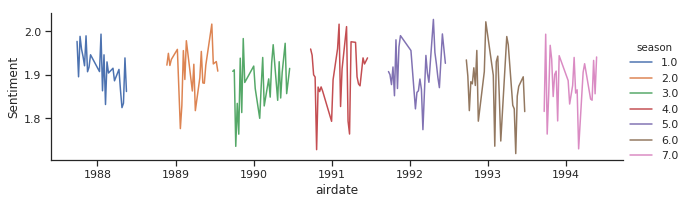

In [371]:
import seaborn
seaborn.set(style='ticks')
matplotlib.rcParams['figure.figsize'] = [10,5]
scores = lines2.groupby(['Episode','airdate'])[['Sentiment','season']].mean().reset_index().dropna()
# scores.head()
# scores['idx'] = scores.index
fg = seaborn.FacetGrid(data=scores, hue='season',aspect=3)
fg.map(plt.plot,'airdate', 'Sentiment').add_legend()

In [264]:
# who are the major characters
from collections import Counter
Counter(lines2.Character.tolist()).most_common(10)

[('PICARD', 10647),
 ('', 10634),
 ('RIKER', 6175),
 ('DATA', 5559),
 ('LAFORGE', 4017),
 ('WORF', 3099),
 ('CRUSHER', 2872),
 ('TROI', 2773),
 ('WESLEY', 1155),
 ('Q', 528)]

In [380]:
character_sent = lines2.groupby(['Episode','Character','airdate'])[['Sentiment','season']].mean().reset_index().dropna()
character_major = ['PICARD', 'DATA', 'LAFORGE', 'TROI', 'RIKER', 'WORF', 'CRUSHER','LWAXANA','Q']
character_sent = character_sent[character_sent['Character'].isin(character_major)]
character_sent.head(20)

Episode Character    airdate  Sentiment  season
22176   Encounter at Farpoint   CRUSHER 1987-09-28   1.933333     1.0
23232   Encounter at Farpoint      DATA 1987-09-28   2.000000     1.0
56144   Encounter at Farpoint   LAFORGE 1987-09-28   2.000000     1.0
81136   Encounter at Farpoint    PICARD 1987-09-28   2.022472     1.0
84128   Encounter at Farpoint         Q 1987-09-28   2.187500     1.0
89056   Encounter at Farpoint     RIKER 1987-09-28   1.938144     1.0
111760  Encounter at Farpoint      TROI 1987-09-28   1.822222     1.0
117216  Encounter at Farpoint      WORF 1987-09-28   1.920000     1.0
141505          The Naked Now   CRUSHER 1987-10-05   1.743590     1.0
142561          The Naked Now      DATA 1987-10-05   1.888889     1.0
175473          The Naked Now   LAFORGE 1987-10-05   1.764706     1.0
200465          The Naked Now    PICARD 1987-10-05   2.000000     1.0
208385          The Naked Now     RIKER 1987-10-05   1.772727     1.0
231089          The Naked Now      TROI 1987-10-05   2.000000     1.0
236545          The Naked Now      WORF 1987-10-05   2.000000     1.0
260834         Code Of Honour   CRUSHER 1987-10-12   1.538462     1.0
261890         Code Of Honour      DATA 1987-10-12   2.000000     1.0
294802         Code Of Honour   LAFORGE 1987-10-12   1.875000     1.0
319794         Code Of Honour    PICARD 1987-10-12   2.091954     1.0
327714         Code Of Honour     RIKER 1987-10-12   2.133333     1.0

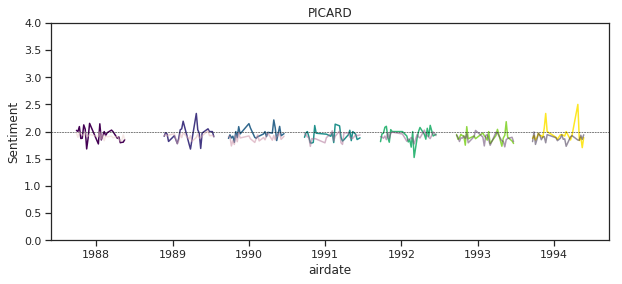

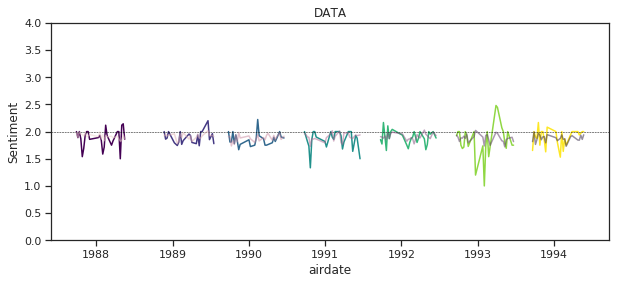

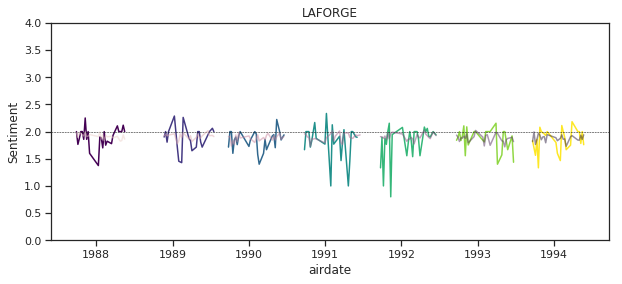

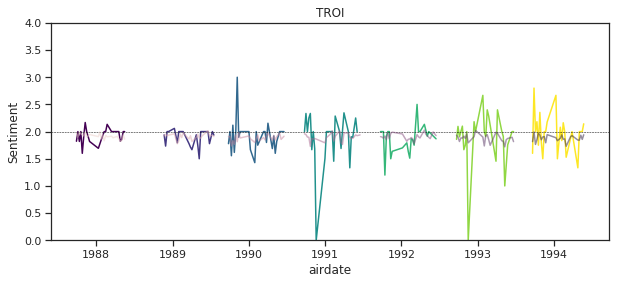

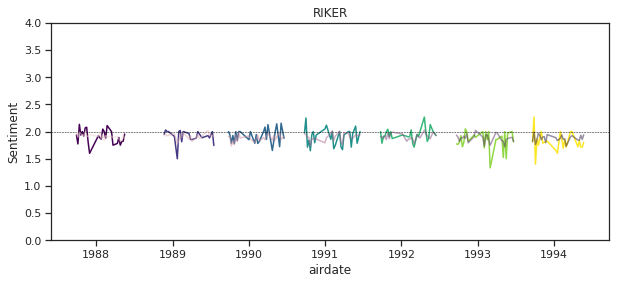

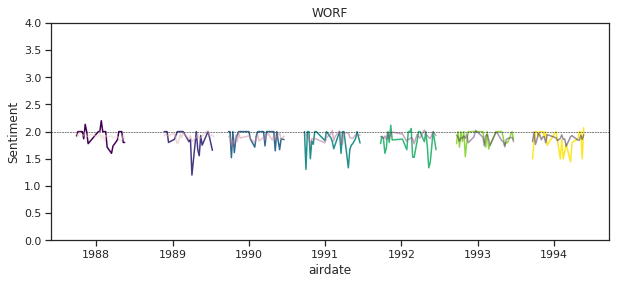

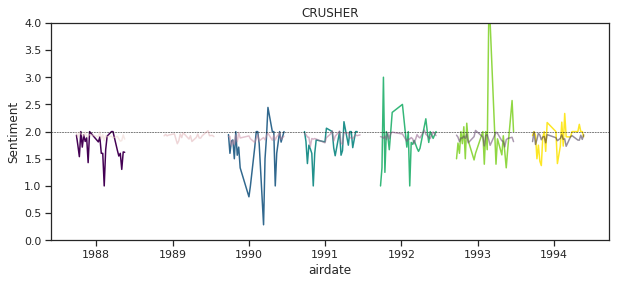

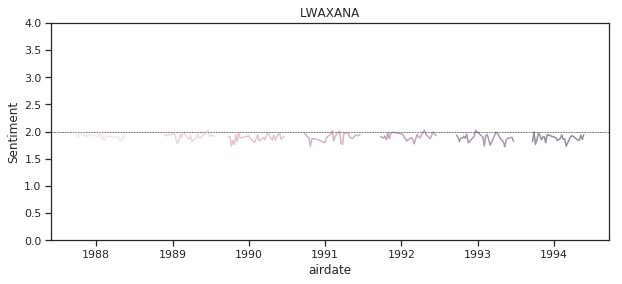

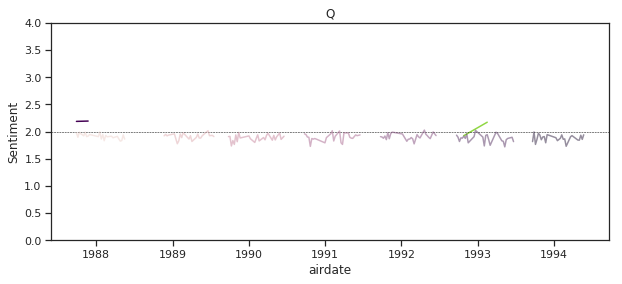

In [384]:
character_sent.season = character_sent.season.astype(float)
df_holder = {}
for char in character_major:
    fig = plt.figure(figsize=(10,4))
    ax = fig.add_subplot(111)
    df_holder[char] = character_sent[character_sent.Character == char]
    g = seaborn.lineplot(x='airdate',y='Sentiment',data=df_holder[char], hue='season',ax=ax, legend=False, palette="viridis")
    ax.set_title(char)
    ax.set_ylim(0,4)
    ax.axhline(y=2,color='black',linewidth=0.5,linestyle='--')
    fg = seaborn.lineplot(x='airdate',y='Sentiment',
                          data=scores,ax=ax, legend=False,hue='season',
                          alpha=0.5,markers=True)
#     fg.map(plt.plot,'airdate', 'Sentiment')

In [391]:
# let's look at the episode authors
episode_sent = lines2.groupby(['Episode','author','airdate'])['Sentiment','season'].mean().reset_index().dropna()
episode_sent.head()

Episode  \
1408           Encounter at Farpoint   
32737                  The Naked Now   
58082                 Code Of Honour   
90291               The Last Outpost   
100676  Where No One Has Gone Before   

                                                        author    airdate  \
1408                            D. C. Fontana,Gene Roddenberry 1987-09-28   
32737   John D. F. Black,J. Michael Bingham,J. Michael Bingham 1987-10-05   
58082                            Katharyn Powers,Michael Baron 1987-10-12   
90291                          Richard Krzmeien,Herbert Wright 1987-10-19   
100676                              Diane Duane,Michael Reaves 1987-10-26   

        Sentiment  season  
1408     1.976642     1.0  
32737    1.895349     1.0  
58082    1.988201     1.0  
90291    1.958656     1.0  
100676   1.942029     1.0

In [408]:
# Now let's look at the sentiment by author
# we need author, num_episodes, sentiment
author_sent = []
author_count = {}
for idx,row in episode_sent.iterrows():
    author_list = row.author.split(",")
    author_list = [x.lstrip().rstrip() for x in author_list]
    sentiment = row.Sentiment
    date = row.airdate
    season = row.season
    for auth in author_list:
        author_sent.append((auth,sentiment,date,season))
        if auth in author_count:
            author_count[auth] += 1
        else:
            author_count[auth] = 1

author_df = pd.DataFrame(author_sent,columns=['Author','Sentiment','Date','Season'])
author_df['Auth_Count'] = author_df.Author.apply(lambda x: author_count[x])
author_df.head()

Author  Sentiment       Date  Season  Auth_Count
0       D. C. Fontana   1.976642 1987-09-28     1.0           4
1    Gene Roddenberry   1.976642 1987-09-28     1.0           3
2    John D. F. Black   1.895349 1987-10-05     1.0           1
3  J. Michael Bingham   1.895349 1987-10-05     1.0           2
4  J. Michael Bingham   1.895349 1987-10-05     1.0           2

In [412]:
# the top ten most prolific authors
author_df.groupby(['Author'])['Auth_Count'].mean().reset_index().sort_values(['Auth_Count'],ascending=False).head(10)

Author  Auth_Count
120  Ronald D. Moore          27
5      Brannon Braga          21
106  René Echevarria          17
54       Joe Menosky          17
83    Michael Piller          16
52       Jeri Taylor          13
77    Maurice Hurley          13
90     Naren Shankar          10
110  Richard Manning           9
36      Hans Beimler           9

In [517]:
top_auths = author_df.groupby(['Author'])['Auth_Count'].mean().reset_index().sort_values(['Auth_Count'],ascending=False).head(10).Author.tolist()
top_auths_df = author_df[author_df.Author.isin(top_auths)].sort_values(['Date'],ascending=True)
top_auths_df.head()

Author  Sentiment       Date  Season  Auth_Count
26  Maurice Hurley   1.993333 1988-01-18     1.0          13
30  Maurice Hurley   1.945824 1988-02-01     1.0          13
41  Maurice Hurley   1.886139 1988-03-21     1.0          13
44  Maurice Hurley   1.886139 1988-03-21     1.0          13
45  Maurice Hurley   1.912317 1988-04-11     1.0          13

In [551]:
from pylab import cm
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

authors = top_auths_df['Author'].drop_duplicates().tolist()

cmap = cm.get_cmap('gist_rainbow',len(authors))
color_list = []
for i in range(cmap.N):
    rgb = cmap(i)[:3] # will return rgba, we take only first 3 so we get rgb
    color_list.append((matplotlib.colors.rgb2hex(rgb)))

patches = []
for i in range(len(color_list)):
    col = color_list[i]
    author = authors[i]
    patch = mpatches.Patch(color=col,label=author)
    patches.append(patch)

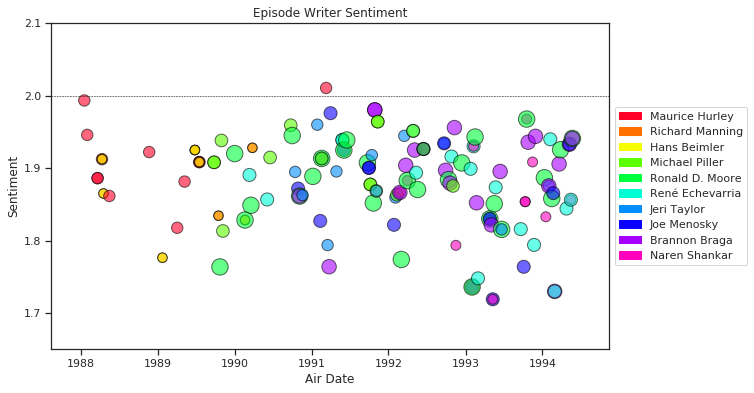

In [611]:
x = top_auths_df.Date.tolist()
y = top_auths_df.Sentiment.tolist()
size = top_auths_df.Auth_Count.tolist()
size = [x*10 for x in size]

color = top_auths_df.Author.apply(lambda x: authors.index(x)).tolist()
l = top_auths_df.Author.tolist()

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
plt.scatter(x, y, s=size,c=color, cmap="gist_rainbow", alpha=0.6, edgecolor='black')
ax.set_title("Episode Writer Sentiment")
ax.set_ylabel("Sentiment")
ax.set_xlabel("Air Date")
ax.set_ylim(1.65,2.1)
ax.axhline(y=2,color='black',linewidth=0.5,linestyle='--')
plt.legend(handles=patches,loc='center left', bbox_to_anchor=(1, 0.5))

Text(0.5, 0, 'Air Date')

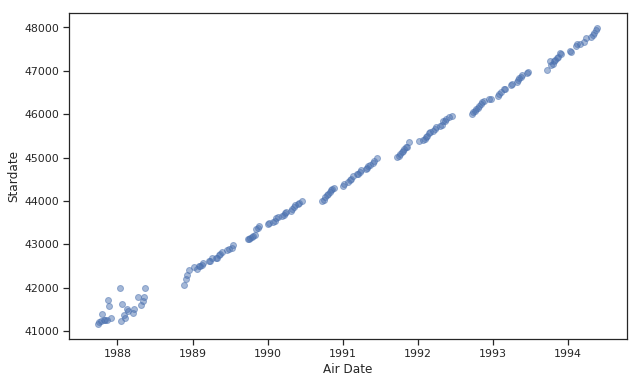

In [612]:
# what does stardates look like?
fig = plt.figure(figsize=(10,6))
episode_meta['airdate'] = pd.to_datetime(episode_meta.airdate)
stardate_df = episode_meta[episode_meta.stardate != "Unknown"]
stardate_df = stardate_df[stardate_df.stardate != '47615.2-47618.4']
stardate_df.stardate = stardate_df.stardate.astype(float)
plt.scatter(x=stardate_df.airdate.tolist(), y=stardate_df.stardate.astype(float).tolist(),alpha=0.5)
plt.ylabel("Stardate")
plt.xlabel("Air Date")

In [640]:
stardate_df['dayofweek'] = stardate_df.airdate.dt.dayofweek
stardate_df['million_viewers'] = stardate_df.million_viewers.apply(lambda x: float(re.sub(r'\[[0-9]\]','',x).replace('Unknown','1.0').replace('N/A','1.0')))
stardate_df.head()

num_overall  num_season                       Episode  stardate  \
0            1           1         Encounter at Farpoint  41153.70   
1            2           2                 The Naked Now  41209.20   
2            3           3                Code Of Honour  41235.25   
3            4           4              The Last Outpost  41386.40   
4            5           5  Where No One Has Gone Before  41263.10   

        director                                                 writers  \
0    Corey Allen                          D. C. Fontana,Gene Roddenberry   
1     Paul Lynch  John D. F. Black,J. Michael Bingham,J. Michael Bingham   
2  Russ Mayberry                           Katharyn Powers,Michael Baron   
3  Richard Colla                         Richard Krzmeien,Herbert Wright   
4     Rob Bowman                              Diane Duane,Michael Reaves   

     airdate  million_viewers  season  dayofweek  
0 1987-09-28             15.7       1          0  
1 1987-10-05             11.5       1          0  
2 1987-10-12              9.5       1          0  
3 1987-10-19              8.9       1          0  
4 1987-10-26             10.5       1          0

In [658]:
lst = [(x-8.8)/(17.4-8.8)*1000 for x in stardate_df.million_viewers.tolist()]
lst  = [x if x > 0 else 10.0 for x in lst]
lst
# 17.4 8.9

[802.3255813953488,
 313.95348837209303,
 81.39534883720924,
 11.627906976744148,
 197.67441860465112,
 383.7209302325581,
 453.4883720930232,
 197.67441860465112,
 255.81395348837205,
 174.4186046511628,
 313.95348837209303,
 174.4186046511628,
 302.3255813953489,
 220.93023255813944,
 244.18604651162792,
 162.79069767441848,
 23.255813953488296,
 151.16279069767432,
 220.93023255813944,
 186.04651162790697,
 104.65116279069754,
 104.65116279069754,
 69.76744186046508,
 162.79069767441848,
 244.18604651162792,
 174.4186046511628,
 10.0,
 10.0,
 220.93023255813944,
 232.55813953488376,
 255.81395348837205,
 290.6976744186047,
 290.6976744186047,
 220.93023255813944,
 162.79069767441848,
 209.30232558139528,
 127.90697674418603,
 34.88372093023244,
 104.65116279069754,
 174.4186046511628,
 139.53488372093017,
 46.51162790697659,
 11.627906976744148,
 23.255813953488296,
 69.76744186046508,
 116.27906976744188,
 232.55813953488376,
 10.0,
 93.02325581395338,
 93.02325581395338,
 127.9069

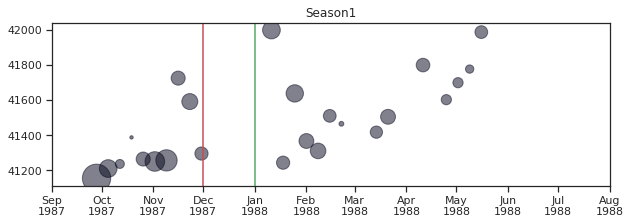

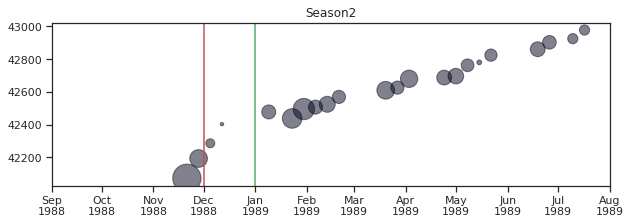

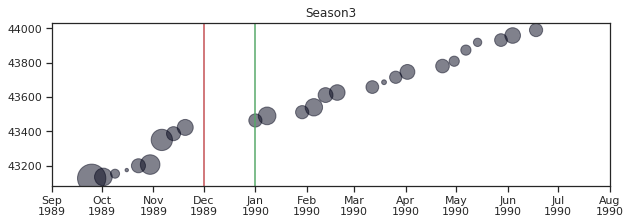

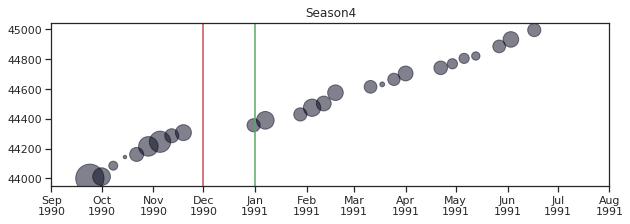

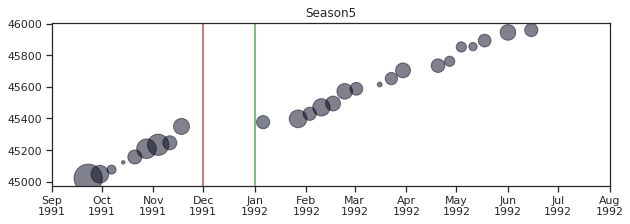

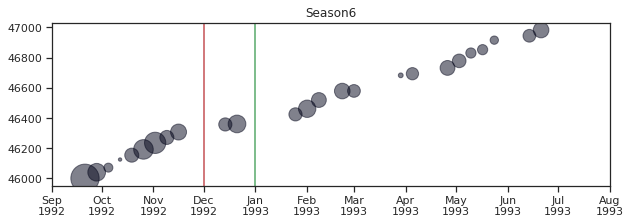

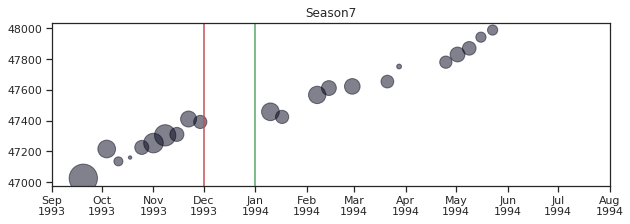

In [659]:
import matplotlib.dates as mdates
for season in range(1,8):
    fig = plt.figure(figsize=(10,3))
    ax = fig.add_subplot(111)
    season_df = stardate_df[stardate_df.season == season]
    x = season_df.airdate.tolist()
    y = season_df.stardate.tolist()
    c = season_df.dayofweek.tolist()
    plt.scatter(x=x, y=y,c=c,alpha=0.5,s=lst)
    start_year = str(min(x).year)
    end_year = str(max(x).year)
    plt.xlim(pd.Timestamp(start_year+'-09'),pd.Timestamp(end_year+'-08'))
    plt.axvline(x=pd.Timestamp(start_year+'-12'),c='r')
    plt.axvline(x=pd.Timestamp(end_year+'-01'),c='g')
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b\n%Y'))
    plt.title('Season'+str(season))
    plt.show()
# plt.ylabel("Stardate")
# plt.xlabel("Air Date")

In [630]:
stardate_df[(stardate_df.airdate < pd.Timestamp('1993-01')) & (stardate_df.airdate > pd.Timestamp('1992-12'))].head()

num_overall  num_season                     Episode  stardate  \
134          135          10  Chain of Command, part one   46357.4   
135          136          11    Chain of Command, Part 2   46360.8   

            director                           writers    airdate  \
134  Robert Scheerer  Frank Abatemarco,Ronald D. Moore 1992-12-14   
135       Les Landau                  Frank Abatemarco 1992-12-21   

    million_viewers  season  dayofweek  
134         10.2[7]       6          0  
135         12.9[7]       6          0